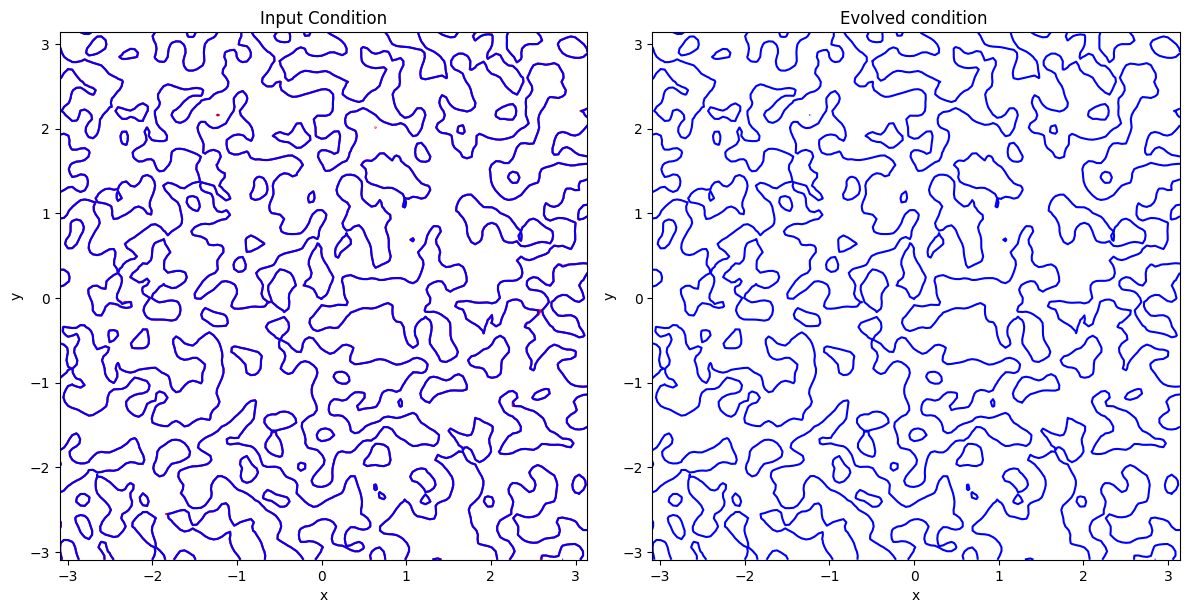

In [27]:
import jax
import numpy as np
import jax.random as random
import jax.numpy as jnp
import jax.numpy.fft as jfft
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from numpy import sqrt
from numpy import round
from matplotlib import pyplot as plt
from matplotlib import contour
from jax.numpy.fft import fft2, ifft2
from jax.numpy.fft import fftn, ifftn
from numpy import real
from jax.example_libraries.stax import serial, Gelu
from jax.example_libraries.optimizers import optimizer, make_schedule
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter






def allen_cahn_equation(uk, total_steps=1):

    # Parameters
    N = 128  # Number of grid points
    eps = 0.05  # Epsilon
    lr = 0.1  # Learning rate
    dt = 0.0001  # Time step or time increment
    L = 2 * jnp.pi  # Length of domain
    h = L / N  # Grid spacing

    # Define wavenumbers in x and y directions (Fourier space)
    p = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N // 2), 
                         2 * jnp.pi / L * jnp.arange(-N // 2, 0)])  # Wavenumber in x direction
    q = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N // 2), 
                         2 * jnp.pi / L * jnp.arange(-N // 2, 0)])  # Wavenumber in y direction

    # Square of wavenumbers
    p2 = p**2  # Square of wavenumber in x direction
    q2 = q**2  # Square of wavenumber in y direction

    # Create meshgrid for square of wavenumbers
    pp2, qq2 = jnp.meshgrid(p2, q2)

    # Expand pp2 and qq2 to include a channel dimension
    pp2 = jnp.expand_dims(pp2, axis=(0, -1))  # (128, 128) -> (1, 128, 128, 1)
    qq2 = jnp.expand_dims(qq2, axis=(0, -1))  # (128, 128) -> (1, 128, 128, 1)

    # Broadcast pp2 and qq2 to match the shape of uk
    pp2 = jnp.broadcast_to(pp2, (1, 128, 128, 3))  # (1, 128, 128, 1) -> (1, 128, 128, 3)
    qq2 = jnp.broadcast_to(qq2, (1, 128, 128, 3))  # (1, 128, 128, 1) -> (1, 128, 128, 3)

    for _ in range(total_steps):

        cahn = eps**2
        uk = jnp.real(uk)

        # Check shapes for debugging
        # print(f"pp2 shape after broadcasting: {pp2.shape}")  # Expected: (1, 128, 128, 3)
        # print(f"qq2 shape after broadcasting: {qq2.shape}")  # Expected: (1, 128, 128, 3)
        # print(f"uk shape before broadcasting: {uk.shape}")  # Expected: (1, 128, 128, 3)

        # Compute denominator in Fourier space
        denominator = cahn + dt * (2 + cahn * (pp2 + qq2))  # Shape: (1, 128, 128, 3)
        # print(f"denominator shape: {denominator.shape}")  # Expected: (1, 128, 128, 3)

        # Perform FFT calculations
        s_hat = jfft.fft2(cahn * uk - dt * (uk**3 - 3 * uk))  # Shape: (1, 128, 128, 3)
        v_hat = s_hat / denominator  # Shape: (1, 128, 128, 3)
        uk = jfft.ifft2(v_hat)  # Shape: (1, 128, 128, 3)

        # Check results
        # print(f"s_hat shape: {s_hat.shape}")  # Expected: (1, 128, 128, 3)
        # print(f"v_hat shape: {v_hat.shape}")  # Expected: (1, 128, 128, 3)
        # print(f"uk shape after computation: {uk.shape}")  # Expected: (1, 128, 128, 3)

    return jnp.real(uk)  # Return only the real part


# Parameters
N = 128 # no. of grid points
eps = 0.05 # epsillon 
lr = 0.1 # learning rate
dt = 0.0001 # time step or time increment
L = 2 * jnp.pi # length of domian
h = L/N # spacing between grid or length of grid





x = jnp.linspace(-0.5 * L + h, 0.5 * L, N)
y = jnp.linspace(-0.5 * L + h, 0.5 * L, N)


theta = jnp.arctan2(y, x)
# Generate input condition
xx, yy = jnp.meshgrid(x, y)

uk = np.load('data_generation/u_test.npy')

final_state = allen_cahn_equation(uk[0])

# Plot the initial and final states
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


input_condition = uk[0, :, :, 0]  # This extracts the 2D array of shape (128, 128)
model_prediction = final_state[0, :, :, 0]  # This extracts the 2D array of shape (128, 128)



# axs[0].imshow(input_condition)
axs[0].contour(x, y, jnp.real(input_condition.T), levels=[0], colors="red")
axs[0].contour(x, y, jnp.real(model_prediction.T), levels=[0], colors="blue")
# axs[0].contour(x, y, jnp.real(model_prediction.T), levels=[0], colors="blue")

axs[0].set_title('Input Condition')
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')


axs[1].contour(x, y, jnp.real(model_prediction.T), levels=[0], colors="blue")
# axs[1].imshow(model_prediction)
axs[1].set_title('Evolved condition ')
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')


plt.tight_layout()
plt.show()


